In [88]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import subprocess as sp
import numpy as np
import cftime
import pandas as pd

## Get datasets

In [135]:
dir_ncep2 = '/archive/Raphael.Dussin/datasets/NCEP-R2'
dir_era40 = '/archive/Raphael.Dussin/datasets/ERA40'
dir_core2 = '/archive/gold/datasets/CORE/IAF_v2.0'
#dir_jra55 = '/archive/gold/datasets/reanalysis/JRA55-do/v1.5.0/original'
dir_jra55 = '/work/Raphael.Dussin/corrected_precips/jra55_zarr'
#dir_erainterim = '/archive/Raphael.Dussin/ERAinterim/nc_daily'
#dir_merra =
dir_era5 = '/archive/uda/ERA5/'

In [3]:
def unarchive_files(flist):
    unarch = "dmget "
    for f in flist:
        unarch += f"{f} "
    out = sp.check_call(unarch, shell=True)
    return out

#### NCEP-R2

In [5]:
flist_ncep = glob(f"{dir_ncep2}/prate.sfc.gauss.*.nc")
unarchive_files(flist_ncep)

0

In [6]:
ncepr2 = xr.open_mfdataset(flist_ncep)

#### ERA-40

In [7]:
flist_era40 = glob(f"{dir_era40}/ERA40_precip_*.nc")
flist_era40 += glob(f"{dir_era40}/ERA40_snow_*.nc")

unarchive_files(flist_era40)

0

In [78]:
era40 = xr.open_mfdataset(flist_era40)

#### CORE2

In [80]:
flist_core2 = glob(f"{dir_core2}/ncar_precip.1948-2007.nomads.nc")

unarchive_files(flist_core2)

0

In [107]:
core2 = xr.open_mfdataset(flist_core2, decode_times=False)
core2["TIME"] = pd.date_range(start='1948-01-15', periods=len(core2["TIME"]), freq='1M')

#### JRA-55

In [136]:
jra55 = xr.open_zarr(dir_jra55, consolidated=True)

#### ERA-5

In [112]:
flist_era5 = glob(f"{dir_era5}/pr_total/*.nc")

unarchive_files(flist_era5)

0

In [168]:
era5 = xr.open_mfdataset(flist_era5, chunks={"time": 10})

In [169]:
era5

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 350633)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01T07:00:00 ... 2018-12-31T23:00:00
Data variables:
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(10, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-10 06:30:20 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

### Cell Areas

In [13]:
ncepr2

<xarray.Dataset>
Dimensions:    (lat: 94, lon: 192, nbnds: 2, time: 61364)
Coordinates:
  * lat        (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time       (time) datetime64[ns] 1979-01-01 ... 2020-12-31T18:00:00
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] dask.array<chunksize=(1460, 2), meta=np.ndarray>
    prate      (time, lat, lon) float32 dask.array<chunksize=(1460, 94, 192), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.0
    title:          4x Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2020/02 by NOAA/ESRL/PSD\nConverted to chunked, d...

In [19]:
# NCEP-R2

lon = ncepr2['lon'].values
lat = ncepr2['lat'].values
lat_bnds = np.concatenate((np.array([90]), 0.5 * (lat[:-1] + lat[1:]), np.array([-90])), axis=0)

dx = 1.875
dy = - lat_bnds[1:] + lat_bnds[:-1]

lon2, lat2 = np.meshgrid(lon, lat)
dx2, dy2 = np.meshgrid(dx, dy)

area_ncepr2 = 4 * np.pi * np.pi *6378000 * 6378000 * dx2 * dy2 * np.cos(2*np.pi*lat2/360)
darea_ncepr2 = xr.DataArray(data=area_ncepr2, dims=('lat', 'lon'))

In [31]:
#darea_ncepr2.plot()

In [29]:
# ERA40

lon = era40['lon'].values
lat = era40['lat'].values
lat_bnds = np.concatenate((np.array([90]), 0.5 * (lat[:-1] + lat[1:]), np.array([-90])), axis=0)

dx = 1.125
dy = - lat_bnds[1:] + lat_bnds[:-1]

lon2, lat2 = np.meshgrid(lon, lat)
dx2, dy2 = np.meshgrid(dx, dy)

area_era40 = 4 * np.pi * np.pi *6378000 * 6378000 * dx2 * dy2 * np.cos(2*np.pi*lat2/360)
darea_era40 = xr.DataArray(data=area_era40, dims=('lat', 'lon'))

In [32]:
#darea_era40.plot()

In [48]:
# CORE2

lon = core2['LON'].values
lat = core2['LAT'].values
lat_bnds = np.concatenate((np.array([-90]), 0.5 * (lat[:-1] + lat[1:]), np.array([90])), axis=0)

dx = 1.875
dy = lat_bnds[1:] - lat_bnds[:-1]

lon2, lat2 = np.meshgrid(lon, lat)
dx2, dy2 = np.meshgrid(dx, dy)

area_core2 = 4 * np.pi * np.pi *6378000 * 6378000 * dx2 * dy2 * np.cos(2*np.pi*lat2/360)
darea_core2 = xr.DataArray(data=area_core2, dims=('LAT', 'LON'))

In [40]:
#darea_core2.plot()

In [170]:
# ERA-5

lon = era5['longitude'].values
lat = era5['latitude'].values

dx = 0.25
dy = 0.25

lon2, lat2 = np.meshgrid(lon, lat)
dx2, dy2 = np.meshgrid(dx, dy)

area_era5 = 4 * np.pi * np.pi *6378000 * 6378000 * dx2 * dy2 * np.cos(2*np.pi*lat2/360)
darea_era5 = xr.DataArray(data=area_era5, dims=('latitude', 'longitude'))

In [145]:
# JRA-55

lon = jra55['lon'].values
lat = jra55['lat'].values
dy = jra55["lat_bnds"].isel(time=0,bnds=1) - jra55["lat_bnds"].isel(time=0,bnds=0)
dx = jra55["lon_bnds"].isel(time=0,bnds=1) - jra55["lon_bnds"].isel(time=0,bnds=0)

lon2, lat2 = np.meshgrid(lon, lat)
dx2, dy2 = np.meshgrid(dx, dy)

area_jra55 = 4 * np.pi * np.pi *6378000 * 6378000 * dx2 * dy2 * np.cos(2*np.pi*lat2/360)
darea_jra55 = xr.DataArray(data=area_jra55, dims=('lat', 'lon'))

In [147]:
#darea_jra55.plot()

### Dask cluster

In [148]:
from dask.distributed import Client

client = Client("tcp://140.208.147.156:37900")
client

Client Scheduler: tcp://140.208.147.156:37900 Dashboard: http://140.208.147.156:28787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [99]:
#client.close()

## Global timeseries

In [100]:
# sum of LSP and CP
ts_era40 = ((era40["var142"] + era40["var143"]) * darea_era40).sum(dim=["lon", "lat"]) / darea_era40.sum(dim=["lon", "lat"])

In [108]:
# sum of rain + snow
ts_core2 = ((core2["RAIN"] + core2["SNOW"]) * darea_core2).sum(dim=["LON", "LAT"]) / darea_core2.sum(dim=["LON", "LAT"])

In [102]:
ts_ncepr2 = (ncepr2["prate"] * darea_ncepr2).sum(dim=["lon", "lat"]) / darea_ncepr2.sum(dim=["lon", "lat"])

In [171]:
ts_era5 = (era5["tp"] * darea_era5).sum(dim=["longitude", "latitude"]) / darea_era5.sum(dim=["longitude", "latitude"])

In [150]:
ts_jra55 = ((jra55["prra"] + jra55["prsn"]) * darea_jra55).sum(dim=["lon", "lat"]) / darea_jra55.sum(dim=["lon", "lat"])

In [172]:
#ts_era40.load()
#ts_core2.load()
#ts_ncepr2.load()
ts_era5.load()
#ts_jra55.load()
print('done')

done


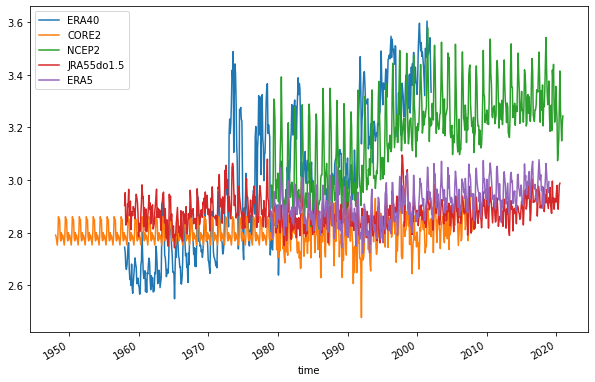

In [181]:
plt.figure(figsize=[10,6])
ax = plt.axes()
(1000 * 4 * ts_era40).resample(time='1MS').mean().plot(ax=ax, label='ERA40')
(86400 * ts_core2).plot(ax=ax, label='CORE2')
(86400 * ts_ncepr2).resample(time='1MS').mean().plot(ax=ax, label='NCEP2')
(86400 * ts_jra55).resample(time='1MS').mean().plot(ax=ax, label='JRA55do1.5')
(1000 * 24 * ts_era5).resample(time='1MS').mean().plot(ax=ax, label='ERA5')
ax.legend()

In [183]:
(1000 * 4 * ts_era40).to_dataset(name='precip').to_netcdf('global_mean_precip_era40.nc')
(86400 * ts_core2).to_dataset(name='precip').to_netcdf('global_mean_precip_core2.nc')
(86400 * ts_ncepr2).to_dataset(name='precip').to_netcdf('global_mean_precip_ncepr2.nc')
(86400 * ts_jra55).to_dataset(name='precip').to_netcdf('global_mean_precip_jra55.nc')
(1000 * 24 * ts_era5).to_dataset(name='precip').to_netcdf('global_mean_precip_era5.nc')

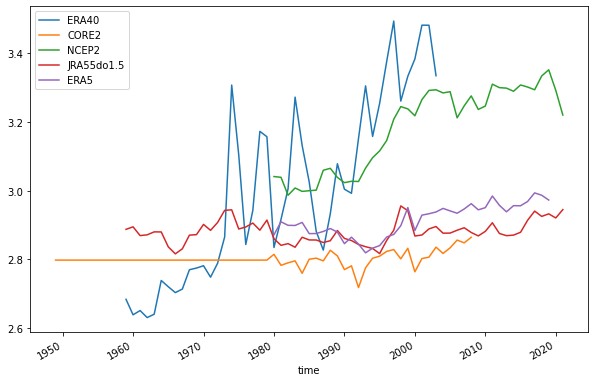

In [182]:
plt.figure(figsize=[10,6])
ax = plt.axes()
(1000 * 4 * ts_era40).resample(time='1Y').mean().plot(ax=ax, label='ERA40')
(86400 * ts_core2).resample(TIME='1Y').mean().plot(ax=ax, label='CORE2')
(86400 * ts_ncepr2).resample(time='1Y').mean().plot(ax=ax, label='NCEP2')
(86400 * ts_jra55).resample(time='1Y').mean().plot(ax=ax, label='JRA55do1.5')
(1000 * 24 * ts_era5).resample(time='1Y').mean().plot(ax=ax, label='ERA5')
ax.legend()

## Zonal means

In [155]:
zmean_ncepr2 = ncepr2['prate'].mean(dim=["time", "lon"])

In [156]:
_ = zmean_ncepr2.load()

In [157]:
zmean_era40 = (era40["var142"] + era40["var143"]).mean(dim=["time", "lon"])

In [158]:
_ = zmean_era40.load()

In [159]:
zmean_core2 = (core2["RAIN"] + core2["SNOW"]).mean(dim=["TIME", "LON"])

In [160]:
_ = zmean_core2.load()

In [161]:
zmean_jra55 = (jra55["prra"] + jra55["prsn"]).mean(dim=("time", "lon"))

In [162]:
_ = zmean_jra55.load()

In [178]:
zmean_era5 = (era5["tp"]).mean(dim=("time", "longitude"))

In [179]:
_ = zmean_era5.load()

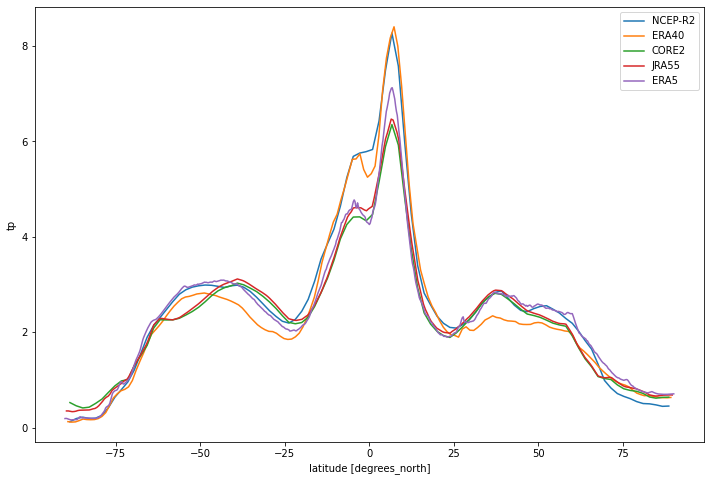

In [180]:
plt.figure(figsize=[12,8])
ax = plt.axes()
(86400 * zmean_ncepr2).plot(ax=ax, label='NCEP-R2')
(1000 * zmean_era40 * 4).plot(ax=ax, label='ERA40')
(86400 * zmean_core2).plot(ax=ax, label='CORE2')
(86400 * zmean_jra55).plot(ax=ax, label='JRA55')
(1000 * 24 * zmean_era5).plot(ax=ax, label='ERA5')

ax.legend()

In [184]:
(86400 * zmean_ncepr2).to_dataset(name='precip').to_netcdf('zonal_mean_precip_ncepr2.nc')
(1000 * zmean_era40 * 4).to_dataset(name='precip').to_netcdf('zonal_mean_precip_era40.nc')
(86400 * zmean_core2).to_dataset(name='precip').to_netcdf('zonal_mean_precip_core2.nc')
(86400 * zmean_jra55).to_dataset(name='precip').to_netcdf('zonal_mean_precip_jra55.nc')
(1000 * 24 * zmean_era5).to_dataset(name='precip').to_netcdf('zonal_mean_precip_era5.nc')

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
